In [1]:
#!pip install torch torch_geometric networkx IPython optuna umap-learn

In [2]:
#!pip install pandas seaborn scikit-learn

In [3]:
import torch, torch.nn as nn, torch.nn.functional as F, random, numpy as np, networkx as nx, pickle, optuna, matplotlib.pyplot as plt, pandas as pd, seaborn as sns, umap, time

from IPython import get_ipython
from IPython.display import display


from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE

from torch_geometric.data import Batch, Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import from_networkx
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch_geometric.nn import GATConv, GATv2Conv, GCNConv, SAGEConv, GINConv, TransformerConv, global_mean_pool
from torch.nn import BatchNorm1d

In [4]:
def generate_graph_family_dataset(num_graphs_per_family=500):
    """
    Generates a dataset of graphs from multiple families with labels.

    Args:
        num_graphs_per_family (int): Number of graphs to generate for each family.

    Returns:
        graphs (list): List of NetworkX graphs.
        labels (list): List of graph family labels (integer-encoded).
    """
    graphs = []
    graph_features = []
    node_features = []
    labels = []
    families = ["erdos_renyi", "barabasi_albert", "watts_strogatz", "stochastic_block_model", "holme_kim"]

    for family in families:
        for i in range(num_graphs_per_family):
            num_nodes = random.randint(1_000, 1_000_000)  # Number of nodes, used to define some families

            if family == "erdos_renyi":
                #erdos reyni graph, defined by number of nodes and probability of an edge connecting each node pair
                p = random.uniform(0.05, 0.5)
                G = nx.erdos_renyi_graph(num_nodes, p)
            elif family == "barabasi_albert":
                #barabasi albert graph, defined by number of nodes, and number of edges attached to each new node (preferential attachment)
                m = random.randint(1, min(num_nodes // 2, 10))
                G = nx.barabasi_albert_graph(num_nodes, m)
            elif family == "watts_strogatz":
                #watts strogatz graph, defined by connecting each node to k neigbours and probability k of rewiring an edge to another node
                k = random.randint(2, num_nodes // 2)
                p = random.uniform(0.2, 0.9)
                G = nx.watts_strogatz_graph(num_nodes, k, p)
            elif family == "stochastic_block_model":
                #stochastic block model, defined by number of blocks of nodes, size of blocks, and probablilty matrix (symmetric) of a connection between and within blocks
                num_blocks = random.randint(3, 5)  # Number of communities
                block_sizes = [random.randint(10, 20) for i in range(num_blocks)]
                # Create lower left triangle of probability matrix
                p_within = np.random.uniform(0.5, 0.9)  # Strong within-block edges
                # Generate a symmetric matrix for between-block connection probabilities
                p_between = np.random.uniform(0.01, 0.2, size=(num_blocks, num_blocks))
                p_matrix = (p_between + p_between.T) / 2  # Symmetrize
                # Fill diagonal with within-block probabilities
                np.fill_diagonal(p_matrix, p_within)
                G = nx.stochastic_block_model(block_sizes, p_matrix)
            elif family == "holme_kim":
                G = nx.powerlaw_cluster_graph(num_nodes, random.randint(1, min(num_nodes // 2, 10)), p=random.uniform(0.5, 0.9))


            # Ensure the graph is connected, if not connected replace graph with smallest connected subgraph
            if not nx.is_connected(G):
              largest_connected_subgraph = max(nx.connected_components(G), key=len)
              G = G.subgraph(largest_connected_subgraph).copy()

            node_features.append(compute_node_features(G))
            graph_features.append(compute_graph_features(G))
            graphs.append(G)
            labels.append(families.index(family))  # Integer-encode family names

    return graphs, node_features, graph_features, np.array(labels)

In [5]:
def compute_node_features(G):
    """
    Generates local (node-level) features for given graph:

    Args:
        G: NetworkX graph
    Returns:
        node_features_dict: dictionary with key-value pairs of node feature names and their values (numpy arrays)

    """
    #degree: number of edges for each node
    degree = np.array([d for _, d in G.degree()])
    #clustering: clustering coeff for each node (fraction of possible triangles that exist)
    clustering = np.array(list(nx.clustering(G).values()))
    #pagerank: measure of relative importance for each node
    pagerank = np.array(list(nx.pagerank(G).values()))
    #k-core: k-core is the largest subgraph with nodes of degree k or more. Here, we find the largest value of a k-core containing each node
    k_core = np.array([nx.core_number(G)[n] for n in G.nodes()])
    #local efficiency: average efficiency for the neighbours of each node
    local_efficiency = np.array([nx.local_efficiency(G.subgraph(G.neighbors(n))) if G.degree(n) > 1 else 0 for n in G.nodes()])

    #group features into dictionary and return
    node_features_dict = {
        'Degree':degree,
        'Clustering':clustering,
        'Pagerank':pagerank,
        'K-Core':k_core,
        'Local Efficiency':local_efficiency
        }

    return node_features_dict


In [6]:
def compute_graph_features(G):
    """
    Generates global (graph-level) features for given graph:

    Args:
        G: NetworkX graph
    Returns:
        graph_features_dict: dictionary with key-value pairs of node feature names and their values (scalar vals)

    """

    # Density: How densely connected the graph is
    density = nx.density(G)

    # Degree Variance: Variability in node degrees
    degrees = [d for _, d in G.degree()]
    degree_variance = np.var(degrees)

    # Assortativity: Tendency of nodes to connect to similar-degree nodes
    assortativity = nx.degree_assortativity_coefficient(G) if len(G.nodes) > 1 else 0

    # Diameter: Longest shortest path in the graph (only for connected graphs)
    diameter = nx.diameter(G) if nx.is_connected(G) else float("inf")

    # Betweenness Variance: Variability in node importance in shortest paths
    betweenness = list(nx.betweenness_centrality(G).values())
    betweenness_variance = np.var(betweenness)

    # Closeness Variance: Variability in how easily nodes can reach others
    closeness = list(nx.closeness_centrality(G).values())
    closeness_variance = np.var(closeness)

    # Edge Density Difference: Difference in density between high-degree and low-degree nodes
    median_degree = np.median(degrees)
    high_degree_nodes = [n for n, d in G.degree() if d > median_degree]
    low_degree_nodes = [n for n, d in G.degree() if d <= median_degree]

    if high_degree_nodes and low_degree_nodes:
        high_density = nx.density(G.subgraph(high_degree_nodes))
        low_density = nx.density(G.subgraph(low_degree_nodes))
        edge_density_diff = high_density - low_density
    else:
        edge_density_diff = 0  # If only one group exists, no meaningful difference

    # Modularity: Strength of community structure
    communities = list(nx.community.greedy_modularity_communities(G))
    modularity = nx.community.modularity(G, communities) if len(communities) > 1 else 0

    # group features into dictionary and return
    graph_features_dict = {
        'Density': density,
        'Degree Variance': degree_variance,
        'Assortativity': assortativity,
        'Diameter': diameter,
        'Betweenness Variance': betweenness_variance,
        'Closeness Variance': closeness_variance,
        'Edge Density Difference': edge_density_diff,
        'Modularity': modularity
    }

    return graph_features_dict


In [7]:
def visualise_features(features, labels):
    """
    visualise_features: Generate and display kde and box plots of the distribution of features across the different labels,
    as well as correlation heatmaps

    Args:
        features: dictionary of local/global features with key/value pairs of feature names and their values
        labels: graph families (integer coded)
    Returns:
        None
    """
  # Extract features and labels
    feature_names = list(features[0].keys())
    feature_values = [list(f.values()) for f in features]


#set up df of features and labels for plotting - use names of families instead of integer encoded
    features_dict = dict()
    for name in feature_names:
        features_dict[name]=[]
    features_dict['Graph Family']=[]

    family_names = ["Erdős-Rényi", "Barabási-Albert", "Watts-Strogatz", "Stochastic Block Model", "Holme-Kim"]
    for i in range(len(feature_values)):
        for j in range(len(feature_values[i])):
        #local features are stored as numpy arrays, need to take the mean for plotting
        #global features are scalar vals so can be plotted directly
            if isinstance(feature_values[i][j], np.ndarray):
                features_dict[feature_names[j]].append(np.mean(feature_values[i][j]))
                title="Node Feature Summary Correlation Heatmap"
            else:
                features_dict[feature_names[j]].append(feature_values[i][j])
                title="Graph Feature Summary Correlation Heatmap"
    for label in labels:
        features_dict["Graph Family"].append(family_names[label])

  # Convert to DataFrame
    df = pd.DataFrame(features_dict)
    # Plot distributions - kde plots f
    # max 4 features per row for ease of visuals  
    num_features = len(feature_names)
    num_cols = min(4,num_features)  # Number of columns for subplots
    num_rows = (num_features + num_cols - 1) // num_cols  # Calculate number of rows needed for KDE plots only
    
    # Calculate total number of rows needed for both KDE and box plots
    total_rows = num_rows * 2
    
    fig, axes = plt.subplots(total_rows, num_cols, figsize=(num_cols * 5, total_rows * 5)) 
    fig.tight_layout(pad=3.0)
    axes = axes.ravel()
    
    for i, feature in enumerate(feature_names):
        # KDE plot in the first half of the subplots
        kde_index = i
        sns.kdeplot(data=df, x=feature, hue="Graph Family", fill=True, common_norm=False, palette="Set2", ax=axes[kde_index])
        axes[kde_index].set_title(f"{feature} Distribution")
    
        # Boxplot in the second half of the subplots
        box_index = i + num_features
        axes[box_index].tick_params(axis='x', labelrotation=45)
        axes[box_index].boxplot([df[df['Graph Family'] == family_name][feature] for family_name in family_names], tick_labels=family_names, patch_artist=True)
        axes[box_index].set_title(f"{feature} Boxplot")
    
    plt.show()
  

    # Generate correlation matrix and plot
    corr = df.corr(numeric_only=True)
    plt.figure(figsize=(10, 6))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", square=True)
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [8]:
def get_important_features(features, labels):
    """
    get_important_features: Use repeated runs of Random Forest Classifiers to identify important features
    
    Args:
    features: global/local graph features 
    labels: integer encoded graph family labels
    Returns:
    important_feature_names: list of names of important features following pruning    
    
    """
   
    # Extract features and labels
    feature_names = list(features[0].keys())
    # Create a list to store feature values for all graphs
    all_feature_values = []
    # Iterate through each graph's features
    for graph_features in features:
        # Get the values for each feature in the current graph
        feature_values = list(graph_features.values())
        # If any feature value is a NumPy array, take its mean
        feature_values = [np.mean(val) if isinstance(val, np.ndarray) else val for val in feature_values]
        # Add the feature values for the current graph to the overall list
        all_feature_values.append(feature_values)
        
    feature_importances = []
    #perform 5 iterations of RFC fitting, obtain the mean feature importance from these iterations
    for run in range(5):
        rf_model = RandomForestClassifier()
        # Fit the model using the prepared feature values
        rf_model.fit(all_feature_values, labels)
        
        # Get feature importance scores
        feature_importance_single_run = rf_model.feature_importances_
        feature_importances.append(feature_importance_single_run)
        
    feature_importance = np.mean(feature_importances, axis=0)
    #display feature importances in descending order with cumulative importance appended
    feature_df = pd.DataFrame({'Feature': feature_names , 'Importance': feature_importance})
    sorted_feature_df = feature_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)
    sorted_feature_df['Cumulative Importance'] = sorted_feature_df['Importance'].cumsum()  
    display(sorted_feature_df)
    
    #set threshold for feature importance based on cumulative importance
    #the first n features with the greatest importance that account for at least 80% of the total importance are retained
    threshold = 0.8
    
    n = sorted_feature_df[sorted_feature_df['Cumulative Importance'] >= threshold ]['Importance'].idxmax()
    filtered_df = sorted_feature_df.iloc[:n+1]
    important_feature_names = filtered_df['Feature'].tolist()
    print()
    return important_feature_names #names of important features in feature list

In [9]:
def convert_to_pyg(graphs, node_features, graph_features, labels):
  """
  Convert networkx graphs and corresponding labels identifying family to pytorch geometric format

  Args:
      graphs (list): List of NetworkX graphs.
      node_features (list): List of node features for each graph.
      graph_features (list): List of graph features for each graph.
      labels (list): List of graph family labels.
  Returns:
    pyg_data (list): List of PyG Data objects.
  """
  pyg_data = []
  for i, G in enumerate(graphs):
      data = from_networkx(G)
      node_feature_values = [list(f.values()) for f in node_features][i]
      graph_feature_values = [list(f.values()) for f in graph_features][i]
      #set data.x to be node feature values
      x = torch.tensor(list(zip(*node_feature_values)), dtype=torch.float)
      data.x = x
      #add graph features
      data.graph_features = torch.tensor(graph_feature_values, dtype=torch.float)
      #set data.y to be label identifiers
      data.y = torch.tensor(labels[i], dtype=torch.long)

      # Remove attributes that are unique to one family
      for key in ['block', 'partition','name']:
          if key in data:
              del data[key]

      pyg_data.append(data)

  #shuffle data to mix distribution of families within training/test sets
  random.shuffle(pyg_data)
  return pyg_data

In [10]:
def prepare_datasets(pyg_data, train_ratio=0.8, batch_size=32):
    """
    Splits the PyG dataset into training and testing sets and creates DataLoaders. Default 80/20 train/test

    Args:
        pyg_data (list): List of PyG Data objects.
        train_ratio (float): Proportion of data to use for training.
        batch_size (int): Batch size for DataLoader.

    Returns:
        tuple: Training and testing DataLoaders.
    """
    # Split dataset
    num_train = int(len(pyg_data) * train_ratio)

    train_data = pyg_data[:num_train]
    test_data = pyg_data[num_train:]

    # Create PyG DataLoaders
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

    return train_loader, test_loader

In [11]:
def get_pruned_features(features, important_feature_names):
    """
    get pruned features: remove unimportant features and return list of pruned features

    Args:
        features (dict): current features with key value pairs of feature names and values
        import_feature_names (list): names of the important feature names following pruning pass
    Returns:
        features (dict): pruned features
    """
    feature_names = list(features[0].keys())
    unimportant_features = [key for key in features[0] if key not in important_feature_names]
    print(f'Features to be pruned: {unimportant_features}')
    for data in features:
        for key in unimportant_features:
            del data[key]
    return features


In [12]:
def prune_features(features, labels):
    """
    prune_features: iteratively remove features until only the most important remain

    Args:
        features (dict): graph feature values (can be global or local)
        labels (list): family identifiers (integer encoded)
    Returns:
        features(dict): fullly pruned dictionary of features
        num_current_features: the number of important features
    """
    feature_names = list(features[0].keys())
    num_current_features = len(feature_names)
    num_important_features = 0
    
    features_fully_pruned = False
    #loop until no more features are removed
    while features_fully_pruned==False:
        num_important_features = num_current_features
        #get names of important features, use to prune unimportant
        important_feature_names = get_important_features(features, labels)
        features = get_pruned_features(features, important_feature_names)
        num_important_features = len(important_feature_names)
        print(f"Number of important features: {num_important_features}")
        if num_important_features==num_current_features:
        #no change between loops, features fully pruned
            features_fully_pruned = True
        num_current_features = num_important_features
    visualise_features(features, labels)
    return features, num_current_features

In [13]:
def visualise_embeddings(model, dataloader, device, class_labels):
    """
    visualise_embeddings: plot t-SNE and UMAP visualisation of graph family embeddings
    Args:
        model: trained model
        dataloader: loader for batched data
        device: cuda/cpu
        class_labels: graph family names (not integer-encoded)
    Returns:
        None
    """
    model.eval()
    embeddings = []
    labels = []

    with torch.no_grad():
        for data in dataloader:
            data = data.to(device)
            logits, emb = model(data)  # Extract embeddings
            embeddings.append(emb.cpu().numpy())
            labels.append(data.y.cpu().numpy())

    # Convert to numpy arrays
    embeddings = np.vstack(embeddings)
    labels = np.hstack(labels)

    # Perform tsne reduction
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    tsne_embeddings_2d = tsne.fit_transform(embeddings)

    #perform umap reduction
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1)
    umap_embeddings_2d = reducer.fit_transform(embeddings)


    # Plot tsne embeddings
    df = pd.DataFrame({"x": tsne_embeddings_2d[:, 0], "y": tsne_embeddings_2d[:, 1], "label": labels})
    plt.figure(figsize=(10, 7))
    sns.scatterplot(data=df, x="x", y="y", hue=df["label"].map(lambda x: class_labels[x]), palette="Set2", alpha=0.7)
    plt.title("t-SNE Visualisation of Graph Embeddings")
    plt.show()
    
    # Plot umap embeddings
    df = pd.DataFrame({"x": umap_embeddings_2d[:, 0], "y": umap_embeddings_2d[:, 1], "label": labels})
    plt.figure(figsize=(10, 7))
    sns.scatterplot(data=df, x="x", y="y", hue=df["label"].map(lambda x: class_labels[x]), palette="Set2", alpha=0.7)
    plt.title("UMAP Visualization of Graph Embeddings")
    plt.show()



In [14]:
def comprehensive_evaluation(model, loader, device, metrics, target_names=["ER", "BA", "WS", "SBM", "HK"]):
    """
    Performs a comprehensive evaluation of the model:
        - Confusion Matrix
        - Loss and Accuracy Plots
        - Classification Report
        - ROC Curve and AUC 
        - Precision-Recall Curve and Average Precision
        - Calls visualise_embeddings for t-SNE and UMAP plots
    Args:
        model: trained model
        dataloader: loader for batched data
        device: cuda/cpu
        metrics: values per epoch for training and validation accuracy and loss 
        class_labels: graph family names (not integer-encoded)
    Returns:
        None
    """
    model.eval()
    y_true, y_pred, y_prob = [], [], []
    train_loss_vals, train_acc_vals, validation_loss_vals, validation_acc_vals = metrics
    #get ground truth, predictions and probabilities for plotting
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            logits, emb = model(batch)
            preds = logits.argmax(dim=1).cpu().numpy()
            probs = torch.softmax(logits, dim=1).cpu().numpy()
            y_pred.extend(preds)
            y_prob.extend(probs)
            y_true.extend(batch.y.cpu().numpy())

    # Confusion Matrix - normalised for %age outputs
    cm = confusion_matrix(y_true, y_pred, normalize='pred')
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="coolwarm", xticklabels=target_names, yticklabels=target_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    # Classification Report
    print(classification_report(y_true, y_pred, target_names=target_names, digits=4))


    # ROC Curve and AUC
    if len(set(y_true)) > 1:
        for i in range(len(target_names)):
            fpr, tpr, thresholds = roc_curve(np.array(y_true) == i, np.array(y_prob)[:, i])
            roc_auc = roc_auc_score(np.array(y_true) == i, np.array(y_prob)[:, i])
            plt.plot(fpr, tpr, label=f"Class: {target_names[i]} (AUC = {roc_auc:.2f})")
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc='lower right')
        plt.show()

    # Precision-Recall Curve and Average Precision
    for i in range(len(target_names)):
        precision, recall, thresholds = precision_recall_curve(np.array(y_true) == i, np.array(y_prob)[:, i])
        average_precision = average_precision_score(np.array(y_true) == i, np.array(y_prob)[:, i])
        plt.plot(recall, precision, label=f"Class: {target_names[i]} (AP = {average_precision:.2f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.show()

    # Loss and Accuracy plots, using metrics input
    plt.plot(train_loss_vals, label='Training loss')
    plt.plot(validation_loss_vals, label='Validation loss')
    plt.legend()
    plt.show()

    plt.plot(train_acc_vals, label='Training accuracy')
    plt.plot(validation_acc_vals, label='Validation accuracy')
    plt.legend()
    plt.show()

    #plot t-sne and umap embeddings
    visualise_embeddings(model, loader, device, target_names)



In [15]:
def load_and_preprocess_dataset(filename='graph_dataset.pickle', num_graphs_per_family=1000):
    """
    Looks for dataset and generates new one if unavailable
    Performs feature pruning
    Converts to pyg format

    Args:
        filename: name of pickled dataset
        num_graphs_per_family: number of graphs per family to generate if original dataset unavailable

    Returns:
        pyg_data: graphs in pyg-format, along with retained node and graph-level features, and the ground truth labels
        num_node_features: number of node features retained following pruning
        num_graph_features: number of graph features retained following pruning

    """
    try:
        #look for dataset file, if unavailable, generate new
        with open(filename, 'rb') as f:
            dataset = pickle.load(f)
    except FileNotFoundError:
        print("Dataset file not found. Generating a new dataset...")
        graphs, node_features, graph_features, labels = generate_graph_family_dataset(num_graphs_per_family=num_graphs_per_family)
        #dump new dataset into dict and pickle it
        dataset = {
            'graphs': graphs,
            'node_features': node_features,
            'graph_features': graph_features,
            'labels': labels
        }
        with open(filename, 'wb') as f:
            pickle.dump(dataset, f)
    #retrieve pickled dict
    graphs = dataset['graphs']
    node_features = dataset['node_features']
    graph_features = dataset['graph_features']
    labels = dataset['labels']

    # Prune features
    node_features, num_node_features = prune_features(node_features, labels)
    graph_features, num_graph_features = prune_features(graph_features, labels)

    # Convert to PyG
    pyg_data = convert_to_pyg(graphs, node_features, graph_features, labels)

    return pyg_data, num_node_features, num_graph_features

,Feature,Importance,Cumulative Importance
0,K-Core,0.288629,0.288629
1,Degree,0.262356,0.550985
2,Clustering,0.188119,0.739104
3,Local Efficiency,0.132313,0.871417
4,Pagerank,0.128583,1.000000



Features to be pruned: ['Pagerank']
Number of important features: 4


,Feature,Importance,Cumulative Importance
0,K-Core,0.332569,0.332569
1,Degree,0.323262,0.655832
2,Clustering,0.193110,0.848941
3,Local Efficiency,0.151059,1.000000



Features to be pruned: ['Local Efficiency']
Number of important features: 3


,Feature,Importance,Cumulative Importance
0,Degree,0.363980,0.363980
1,K-Core,0.344118,0.708098
2,Clustering,0.291902,1.000000



Features to be pruned: []
Number of important features: 3


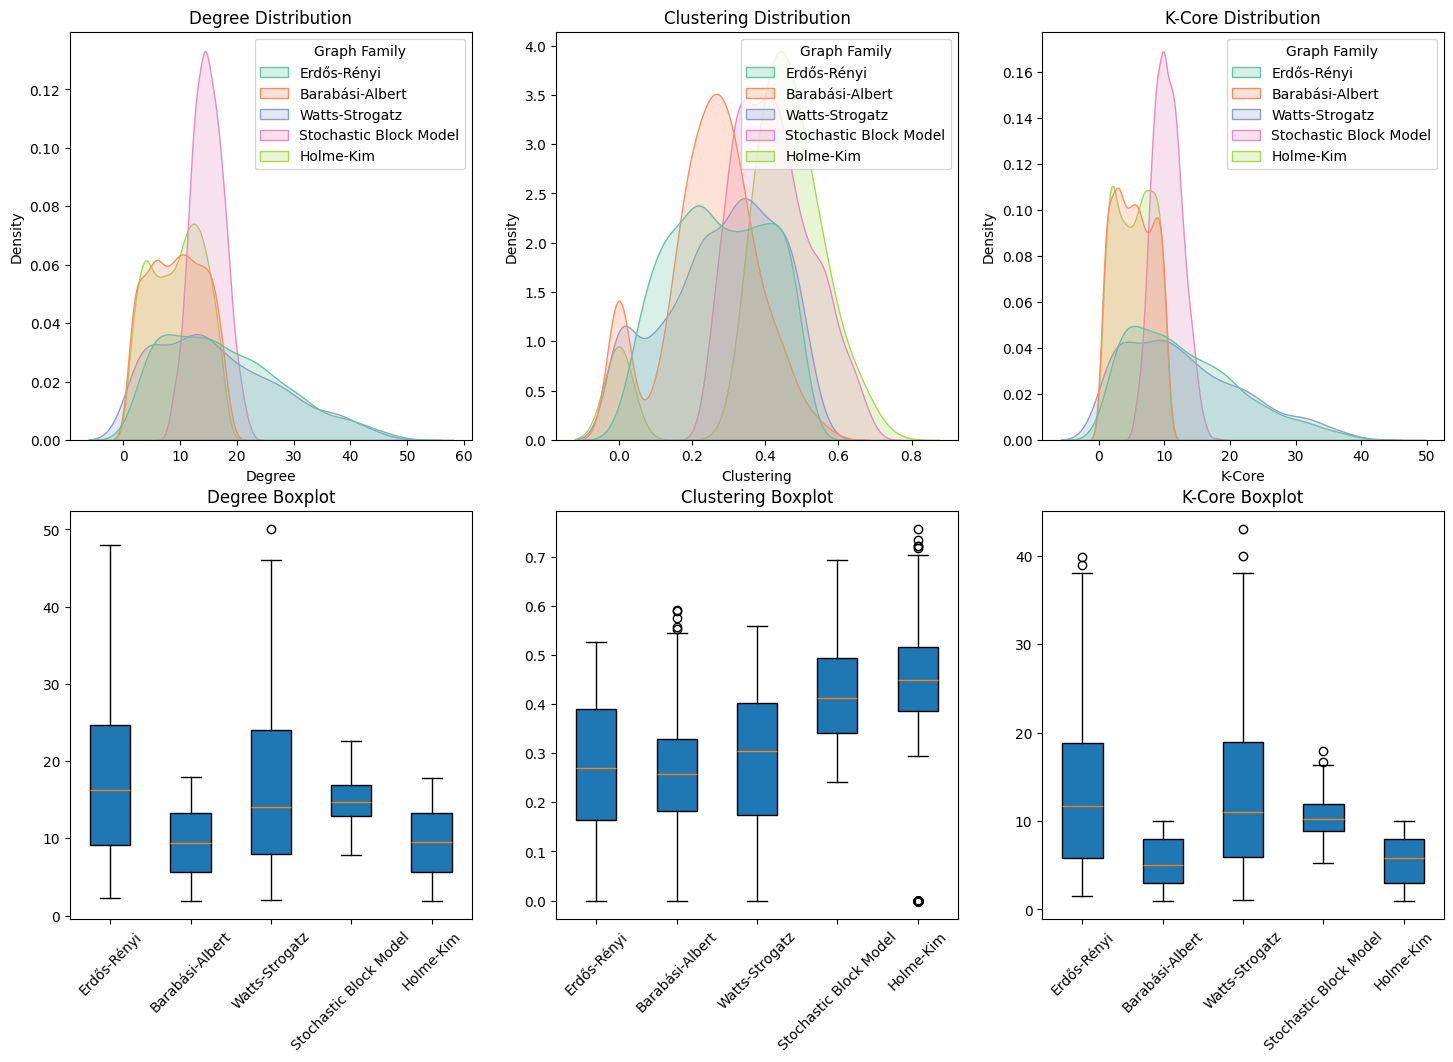

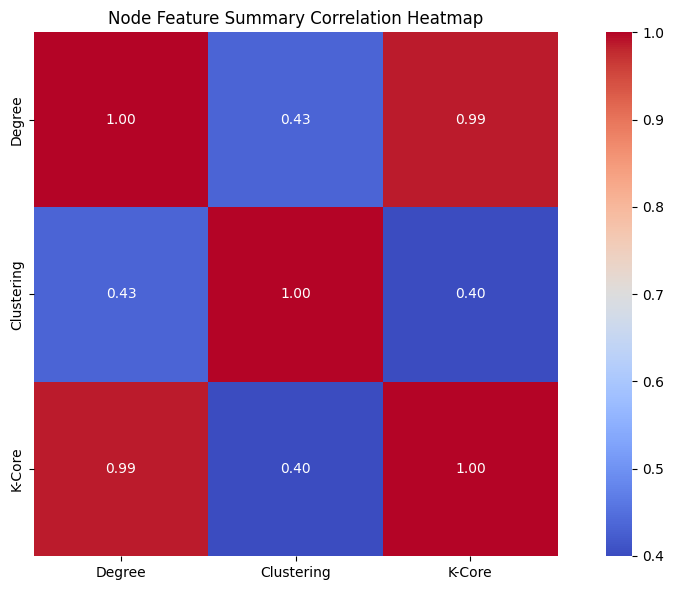

,Feature,Importance,Cumulative Importance
0,Degree Variance,0.193349,0.193349
1,Modularity,0.166103,0.359452
2,Closeness Variance,0.161729,0.521181
3,Assortativity,0.154175,0.675356
4,Betweenness Variance,0.125115,0.800471
5,Edge Density Difference,0.084428,0.884899
6,Density,0.081287,0.966186
7,Diameter,0.033814,1.000000



Features to be pruned: ['Density', 'Diameter', 'Edge Density Difference']
Number of important features: 5


,Feature,Importance,Cumulative Importance
0,Degree Variance,0.248163,0.248163
1,Closeness Variance,0.223555,0.471717
2,Assortativity,0.189246,0.660963
3,Modularity,0.188271,0.849235
4,Betweenness Variance,0.150765,1.000000



Features to be pruned: ['Betweenness Variance']
Number of important features: 4


,Feature,Importance,Cumulative Importance
0,Closeness Variance,0.282762,0.282762
1,Degree Variance,0.262615,0.545378
2,Assortativity,0.240950,0.786327
3,Modularity,0.213673,1.000000



Features to be pruned: []
Number of important features: 4


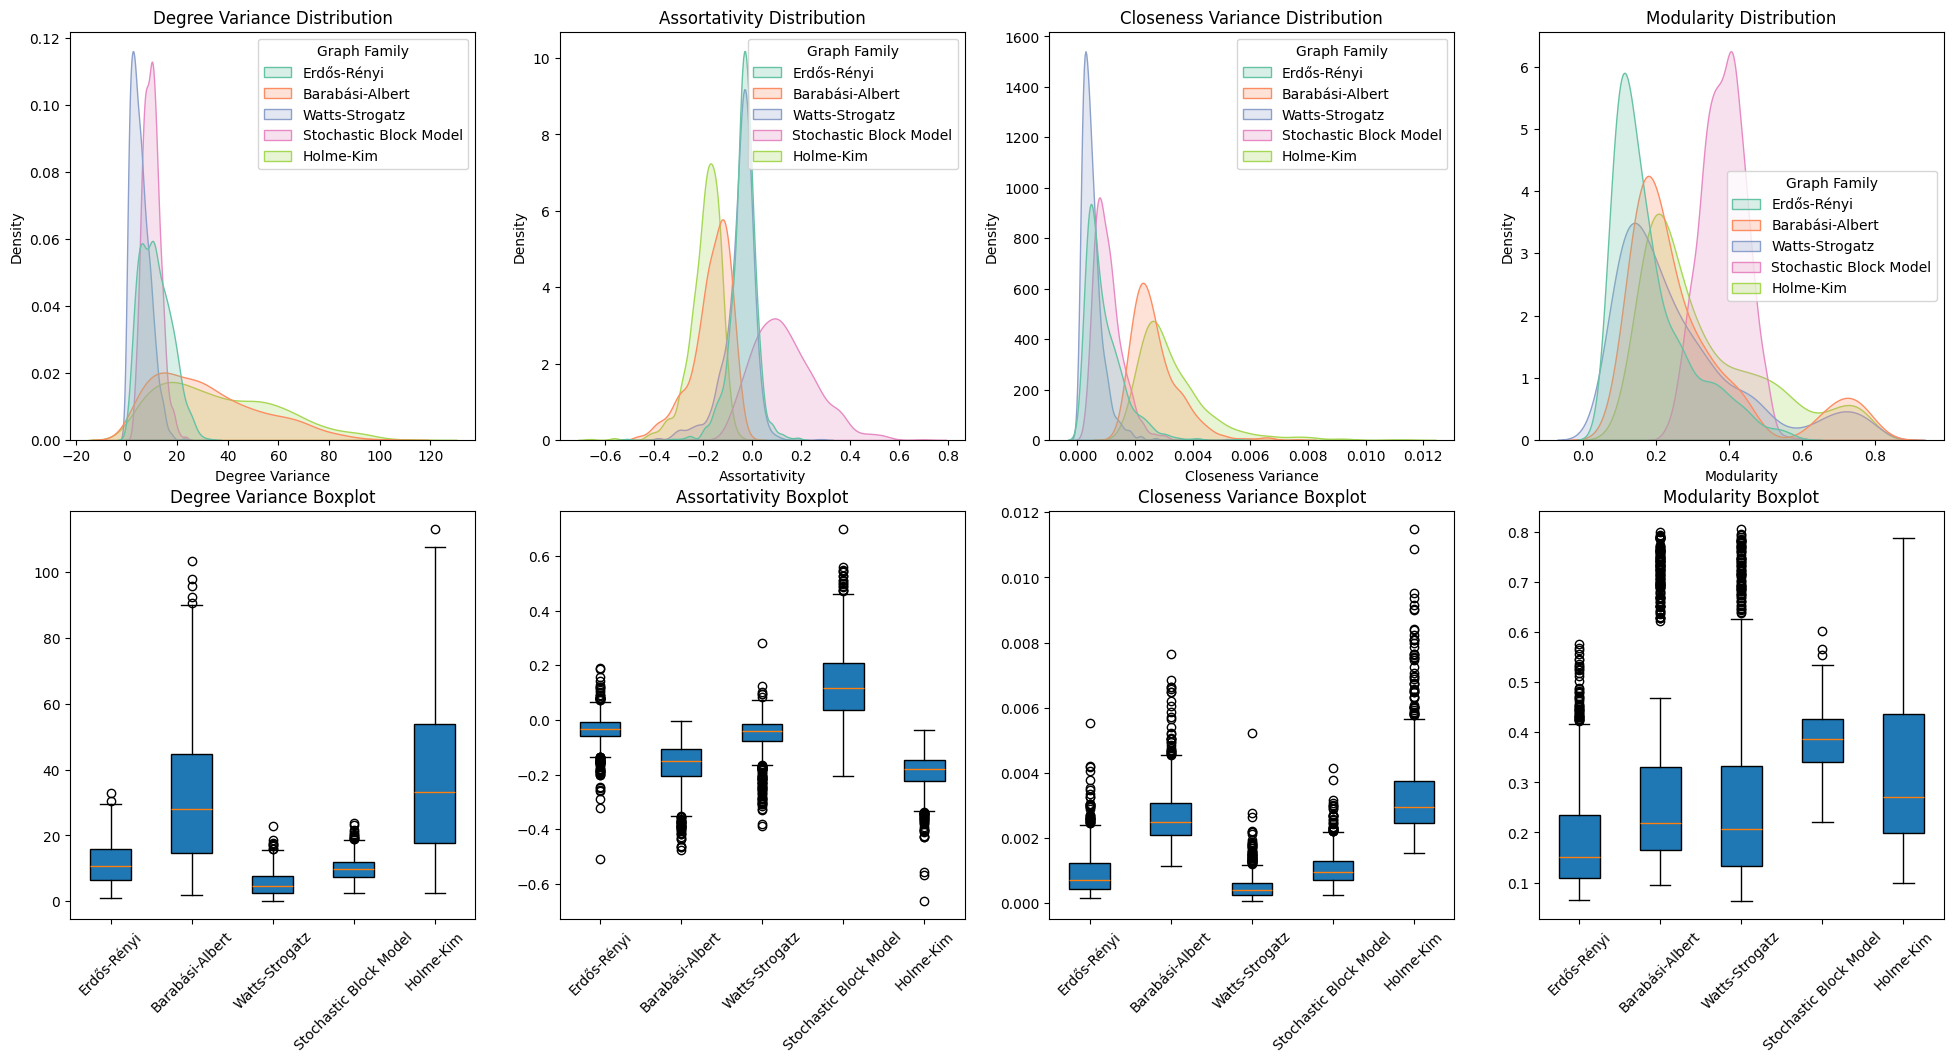

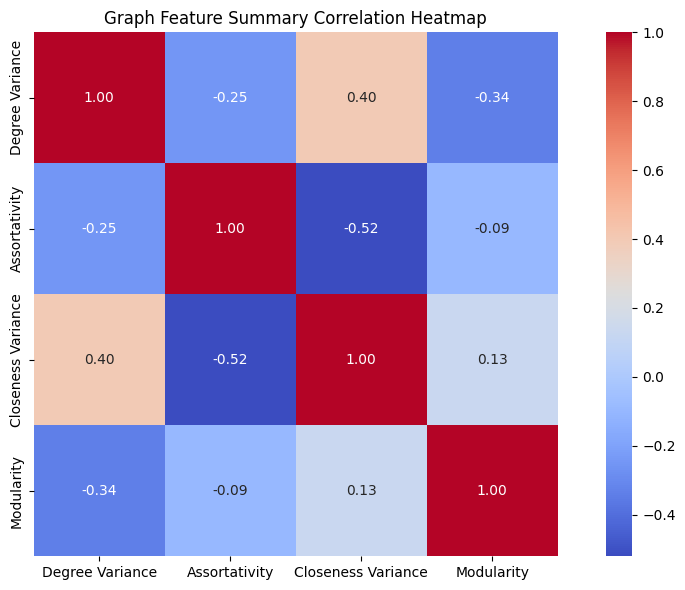

In [16]:
#set seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Load and preprocess data
pyg_data, num_node_features, num_graph_features = load_and_preprocess_dataset()

# Split into training and testing sets
train_loader, test_loader = prepare_datasets(pyg_data)

In [17]:
class GraphFamilyClassifierBase(nn.Module):
    """
    Base class for GNN classififer
    Defines base structure - convolutional layers defined by children - each child has 2 conv layers
    Universal forward() method
    """
    def __init__(self, in_channels, hidden_channels, num_classes, graph_feature_dim, dropout_rate):
        super().__init__()
        self.conv1 = self.define_conv_layer_1(in_channels,hidden_channels)
        self.bn1 = nn.BatchNorm1d(hidden_channels)  # BatchNorm after conv1
        self.conv2 =  self.define_conv_layer_2(hidden_channels,hidden_channels)
        self.bn2 = nn.BatchNorm1d(hidden_channels)  # BatchNorm after conv2
        self.fc1 = nn.Linear(hidden_channels + graph_feature_dim, hidden_channels)
        self.bn3 = nn.BatchNorm1d(hidden_channels)  # BatchNorm before fc2
        self.fc2 = nn.Linear(hidden_channels, num_classes)
        self.dropout = nn.Dropout(dropout_rate) #define dropout layer

    def define_conv_layer_1(self,in_channels,hidden_channels):
        # This method needs to be overridden by child classes
        raise NotImplementedError
    def define_conv_layer_2(self, in_channels,hidden_channels):
        # This method needs to be overridden by child classes
        raise NotImplementedError

    
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.conv1(x, edge_index))
        x = self.bn1(x)  # Apply BatchNorm
        x = self.dropout(x)
        x = F.relu(self.conv2(x, edge_index))
        x = self.bn2(x)  # Apply BatchNorm
        x = self.dropout(x)
        x = global_mean_pool(x, batch)

        # Combine graph-level features
        graph_features = data.graph_features.view(x.shape[0], -1)
        x = torch.cat([x, graph_features], dim=1)

        x = F.relu(self.fc1(x))
        x = self.bn3(x)  # Apply BatchNorm
        x = self.dropout(x)
        #get both logits and embeddings - need embs for plotting t-sne and UMAP
        embeddings = x
        logits = self.fc2(x)

        return logits, embeddings

In [18]:
class GraphFamilyClassifierGAT(GraphFamilyClassifierBase):
    """
    GAT model - 1 attention head per layer
    """
    def define_conv_layer_1(self,in_channels,hidden_channels):
        return GATConv(in_channels, hidden_channels, heads=1, concat=True)
    def define_conv_layer_2(self,in_channels,hidden_channels):
        return GATConv(in_channels, hidden_channels, heads=1, concat=False)

class GraphFamilyClassifierGTN(GraphFamilyClassifierBase):
    """
    GTN model - 1 attention head per layer
    """
    def define_conv_layer_1(self,in_channels,hidden_channels):
        return TransformerConv(in_channels, hidden_channels, heads=1, concat=True)
    def define_conv_layer_2(self,in_channels,hidden_channels):
        return TransformerConv(in_channels, hidden_channels, heads=1, concat=False)

class GraphFamilyClassifierGATV2(GraphFamilyClassifierBase):
    """
    GATV2 model - 1 attention head per layer
    """
    def define_conv_layer_1(self,in_channels,hidden_channels):
        return GATv2Conv(in_channels, hidden_channels, heads=1, concat=True)
    def define_conv_layer_2(self,in_channels,hidden_channels):
        return GATv2Conv(in_channels, hidden_channels, heads=1, concat=False)

class GraphFamilyClassifierGCN(GraphFamilyClassifierBase):
    """
    GCN model
    """
    def define_conv_layer_1(self,in_channels,hidden_channels):
        return GCNConv(in_channels, hidden_channels)
    def define_conv_layer_2(self,in_channels,hidden_channels):
        return GCNConv(in_channels, hidden_channels)

class GraphFamilyClassifierSAGE(GraphFamilyClassifierBase):
    """
    GraphSAGE model
    """
    def define_conv_layer_1(self,in_channels,hidden_channels):
        return SAGEConv(in_channels, hidden_channels)
    def define_conv_layer_2(self,in_channels,hidden_channels):
        return SAGEConv(in_channels, hidden_channels)

class GraphFamilyClassifierGIN(GraphFamilyClassifierBase):  
    """
    GIN model - MLP follows Linear->Relu->Linear
    No additional dropout or norm as this is handled in base model
    """
    def make_gin_mlp(self, input_dim, output_dim):
        return nn.Sequential(
            nn.Linear(input_dim, output_dim),
            nn.ReLU(),
            nn.Linear(output_dim, output_dim)
        )

    def define_conv_layer_1(self, in_channels, hidden_channels):
        mlp = self.make_gin_mlp(in_channels, hidden_channels)
        return GINConv(mlp, train_eps=True)

    def define_conv_layer_2(self, in_channels, hidden_channels):
        mlp = self.make_gin_mlp(in_channels, hidden_channels)
        return GINConv(mlp, train_eps=True)




In [19]:
def train(model, loader, optimizer, criterion, device):
    """
    One training step for given model

    Args:
        model: model to be trained
        loader: dataloader
        optimizer: Adam used
        criterion: Cross-Entropy Loss used
        device: cuda/cpu
    Returns:
        total_loss/len(loader): loss this epoch
        accuracy: accuracy this epoch

    """
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for data in loader:
        data = data.to(device) 
        optimizer.zero_grad()
        out, emb = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Compute accuracy
        pred = out.argmax(dim=1)
        correct += (pred == data.y).sum().item()
        total += data.y.size(0)

    accuracy = correct / total
    return total_loss / len(loader), accuracy

def evaluate(model, loader, criterion, device):
    """
    One validation step for given model

    Args:
        model:model being validated
        loader: dataloader
        criterion: Cross-Entropy Loss used
        device: cuda/cpu

    Returns:
        total_loss/len(loader): validation loss this epoch
        accuracy: validation accuracy this epoch
    """
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for data in loader:  
            data = data.to(device) 
            #will get logits and embeddings from model due to plotting later, discard embeddings here
            out,emb = model(data)
            loss = criterion(out, data.y)
            total_loss += loss.item()

            # Compute accuracy
            pred = out.argmax(dim=1)
            correct += (pred == data.y).sum().item()
            total += data.y.size(0)

    accuracy = correct / total
    return total_loss / len(loader), accuracy

In [20]:
"""
Prep and run Optuna trials
"""
names = ['GAT', 'GCN', 'SAGE', 'GIN', 'GATV2', 'GTN']
num_trials =100*len(names)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def objective(trial):
    # Hyperparameters to tune
    hidden_channels = trial.suggest_categorical("hidden_channels", [32, 64, 96, 128])
    learning_rate = trial.suggest_float("learning_rate", 1e-6, 1e-2, log=True)
    dropout_rate = trial.suggest_float("dropout_rate", 0.05, 0.5)
 
    model_type = trial.number % len(names)  # 0 for GAT, 1 for GCN, 2 for SAGE, 3 for GIN, 4 for GATV2, 5 for TRANS
    #model selection for current trial - round robin
    if model_type == 0:
        model = GraphFamilyClassifierGAT(num_node_features, hidden_channels, 5, num_graph_features, dropout_rate).to(device)
    elif model_type == 1:
        model = GraphFamilyClassifierGCN(num_node_features, hidden_channels, 5, num_graph_features,dropout_rate).to(device)
    elif model_type == 2:
        model = GraphFamilyClassifierSAGE(num_node_features, hidden_channels, 5, num_graph_features,dropout_rate).to(device)
    elif model_type == 3:
        model = GraphFamilyClassifierGIN(num_node_features, hidden_channels, 5, num_graph_features,dropout_rate).to(device)
    elif model_type ==4:
        model = GraphFamilyClassifierGATV2(num_node_features, hidden_channels, 5, num_graph_features,dropout_rate).to(device)
    else:
        model = GraphFamilyClassifierGTN(num_node_features, hidden_channels, 5, num_graph_features,dropout_rate).to(device)


    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)
    criterion = nn.CrossEntropyLoss()

    #start timer
    start = time.time()
    for epoch in range(10):  
        train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = evaluate(model, test_loader, criterion, device)
        scheduler.step(val_loss)  # Update scheduler based on validation loss

        trial.report(val_loss, epoch)  # Report validation loss to Optuna
        if trial.should_prune():
            raise optuna.TrialPruned()  # Prune unpromising trials early
    #get training time     
    end = time.time()
    train_time = end-start
    #get trainable params
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    #set attributes for logging that aren't the criterion for tuning
    trial.set_user_attr("train_time",train_time)
    trial.set_user_attr("num_params", num_params)
    trial.set_user_attr("val_accuracy", val_acc)
    trial.set_user_attr("model_type", names[model_type])
    
    return val_loss  # Minimize validation loss

#set up study - using median pruner with startup equal to number of archs tested, warmup of 5 epochs (half training time)
study = optuna.create_study(direction="minimize", pruner=optuna.pruners.MedianPruner(
        n_startup_trials=len(names), n_warmup_steps=5))
study.optimize(objective, n_trials=num_trials)  # set trials number based on number of architectures

# Get best hyperparameters and model
best_params = study.best_params
best_model_type = study.best_trial.number%len(names)  # 0 for GAT, 1 for GCN, 2 for SAGE, 3 for GIN, 4 for GATV2, 5 for GTN

[I 2025-05-03 08:42:26,960] A new study created in memory with name: no-name-66d6463b-ec8f-4abf-b202-873669c7b00f
[I 2025-05-03 08:44:01,468] Trial 0 finished with value: 0.3165159705094993 and parameters: {'hidden_channels': 128, 'learning_rate': 0.0032025600328367395, 'dropout_rate': 0.28628261914267616}. Best is trial 0 with value: 0.3165159705094993.
[I 2025-05-03 08:44:51,025] Trial 1 finished with value: 0.24294803384691477 and parameters: {'hidden_channels': 96, 'learning_rate': 0.0004365258914430003, 'dropout_rate': 0.167847361573064}. Best is trial 1 with value: 0.24294803384691477.
[I 2025-05-03 08:45:16,652] Trial 2 finished with value: 0.16049452812876552 and parameters: {'hidden_channels': 64, 'learning_rate': 0.0020623924784909423, 'dropout_rate': 0.2931790004358142}. Best is trial 2 with value: 0.16049452812876552.
[I 2025-05-03 08:45:49,150] Trial 3 finished with value: 0.27523556258529425 and parameters: {'hidden_channels': 96, 'learning_rate': 0.003489509726470005, 'd

In [21]:
#display best performing model of each architecture
df = study.trials_dataframe()
df = df.rename(columns = {'user_attrs_train_time':'Training Time','user_attrs_num_params':'Parameters','user_attrs_model_type':'Architecture', 'value':'Validation Loss', 'user_attrs_val_accuracy':'Validation Accuracy', 'params_hidden_channels': 'Hidden Channels','params_dropout_rate': 'Dropout Rate', 'params_learning_rate': 'Learning Rate' })
df = df.loc[:,['Architecture','Hidden Channels', 'Learning Rate','Dropout Rate', 'Parameters', 'Training Time', 'Validation Loss', 'Validation Accuracy']]
#perform groupby - lowest validation loss of each architecture
best_trials_df = df.groupby('Architecture').apply(lambda df: df.loc[df['Validation Loss'].idxmin()], include_groups=False).sort_values(by='Validation Loss')
print("Best performing hyperparameter tunings for each architecture")
print()
best_trials_df

Best performing hyperparameter tunings for each architecture



,Hidden Channels,Learning Rate,Dropout Rate,Parameters,Training Time,Validation Loss,Validation Accuracy
Architecture,,,,,,,
GTN,128.0,0.001085,0.247589,86533.0,121.902942,0.123106,0.957
SAGE,128.0,0.002441,0.178864,52229.0,37.062978,0.132244,0.950
GATV2,64.0,0.003424,0.257714,14213.0,73.906706,0.148002,0.937
GAT,32.0,0.002103,0.076109,2853.0,32.817585,0.190487,0.921
GCN,64.0,0.003189,0.227923,9541.0,34.792415,0.207054,0.908
GIN,96.0,0.003490,0.263300,39079.0,32.374403,0.275236,0.875


In [38]:
# Training loop
def training_loop(model, optimizer, scheduler, criterion, train_loader, test_loader, device, patience=10):
  epoch=0
  max_epochs=100
  train_loss_vals = []
  train_acc_vals = []
  validation_loss_vals = []
  validation_acc_vals = []
  #set up early stopping - based on validation loss
  min_loss=float('inf')
  epochs_without_improvement=0
  while epoch<max_epochs:
      epoch+=1
      train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
      val_loss, val_acc = evaluate(model, test_loader, criterion, device)
      if val_loss<min_loss:
        min_loss=val_loss
        epochs_without_improvement=0
      else:
        epochs_without_improvement+=1
      if epochs_without_improvement>=patience:
        print('No improvement in validation loss for '+str(patience)+' consecutive epochs: Terminate training')
        break
      scheduler.step(val_loss)
      train_loss_vals.append(train_loss)
      train_acc_vals.append(train_acc)
      validation_loss_vals.append(val_loss)
      validation_acc_vals.append(val_acc)
      print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
  return train_loss_vals, train_acc_vals, validation_loss_vals, validation_acc_vals

Best model: GTN
Best hyperparameters for GTN:
Hidden channels: 128
Learning rate: 0.0010847429602701309
Dropout rate: 0.24758906717123053
Training GTN
Epoch 1, Train Loss: 0.7474, Train Acc: 0.6687, Val Loss: 0.5189, Val Acc: 0.7860
Epoch 2, Train Loss: 0.5298, Train Acc: 0.7578, Val Loss: 0.3442, Val Acc: 0.8850
Epoch 3, Train Loss: 0.3734, Train Acc: 0.8495, Val Loss: 0.3393, Val Acc: 0.8500
Epoch 4, Train Loss: 0.3462, Train Acc: 0.8635, Val Loss: 0.2422, Val Acc: 0.9110
Epoch 5, Train Loss: 0.3073, Train Acc: 0.8728, Val Loss: 0.2308, Val Acc: 0.8940
Epoch 6, Train Loss: 0.3038, Train Acc: 0.8768, Val Loss: 0.1826, Val Acc: 0.9330
Epoch 7, Train Loss: 0.2501, Train Acc: 0.9048, Val Loss: 0.1678, Val Acc: 0.9370
Epoch 8, Train Loss: 0.2454, Train Acc: 0.9008, Val Loss: 0.1530, Val Acc: 0.9470
Epoch 9, Train Loss: 0.2320, Train Acc: 0.9067, Val Loss: 0.1957, Val Acc: 0.9280
Epoch 10, Train Loss: 0.2335, Train Acc: 0.9058, Val Loss: 0.1650, Val Acc: 0.9290
Epoch 11, Train Loss: 0.2311

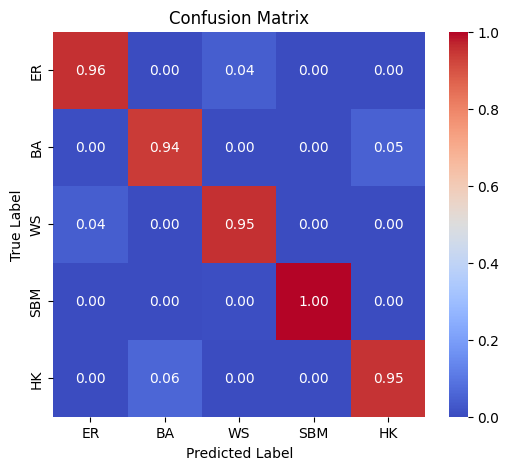

              precision    recall  f1-score   support

          ER     0.9559    0.9559    0.9559       204
          BA     0.9381    0.9479    0.9430       192
          WS     0.9535    0.9624    0.9579       213
         SBM     1.0000    0.9951    0.9975       204
          HK     0.9511    0.9358    0.9434       187

    accuracy                         0.9600      1000
   macro avg     0.9597    0.9594    0.9596      1000
weighted avg     0.9601    0.9600    0.9600      1000



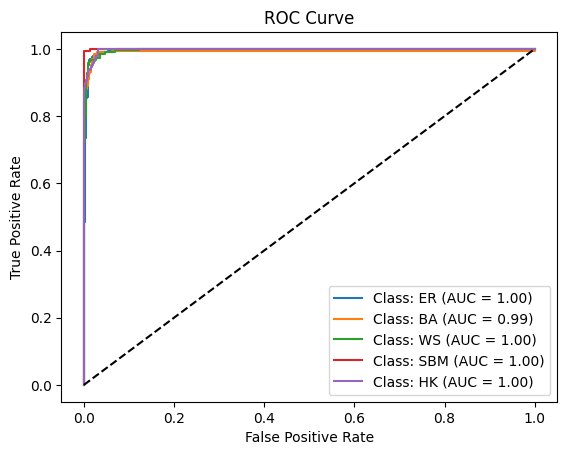

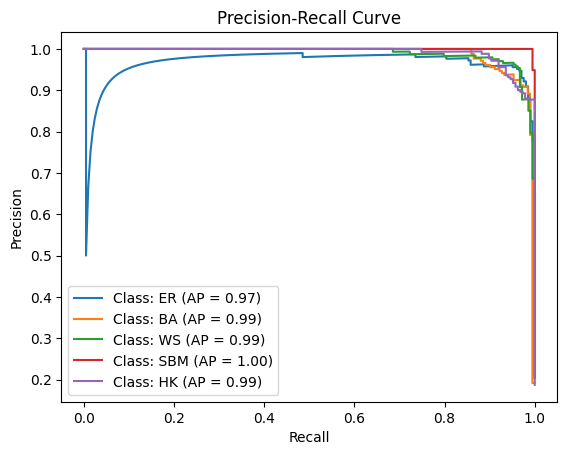

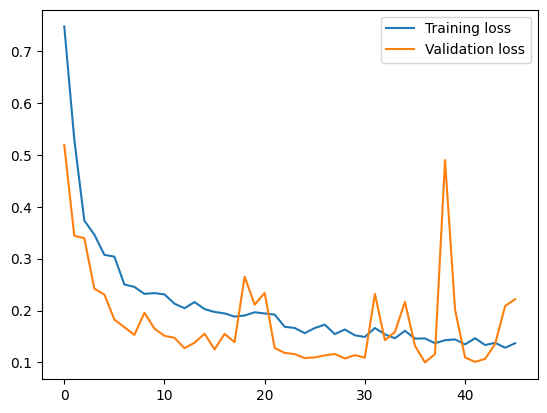

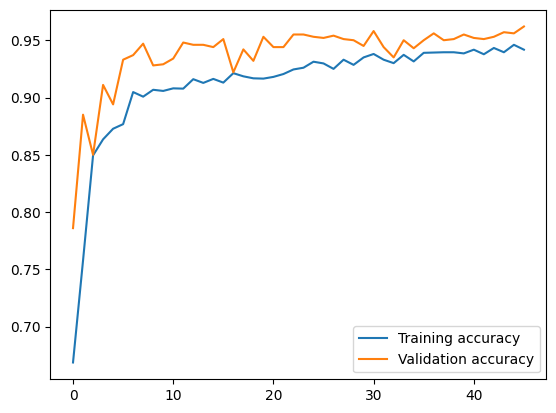

C:\Users\janek\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


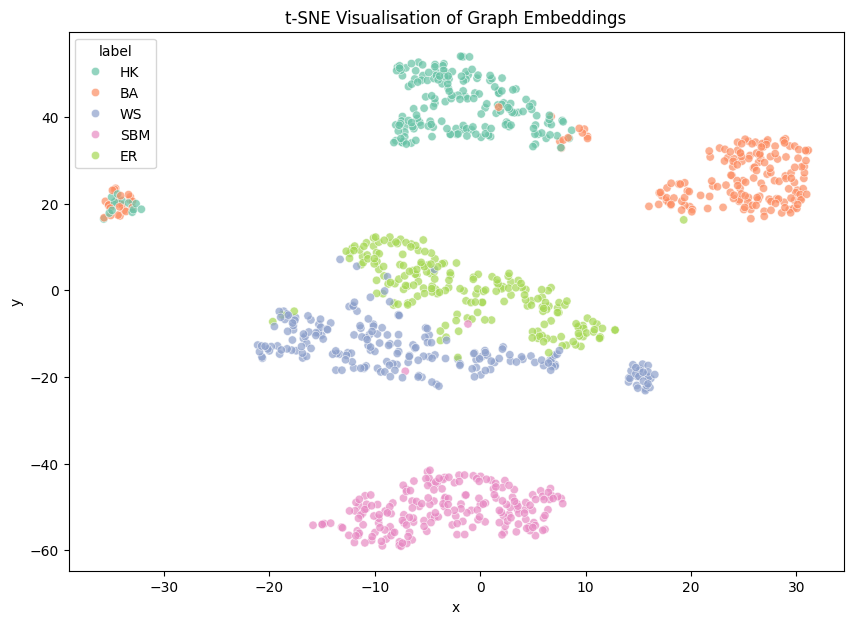

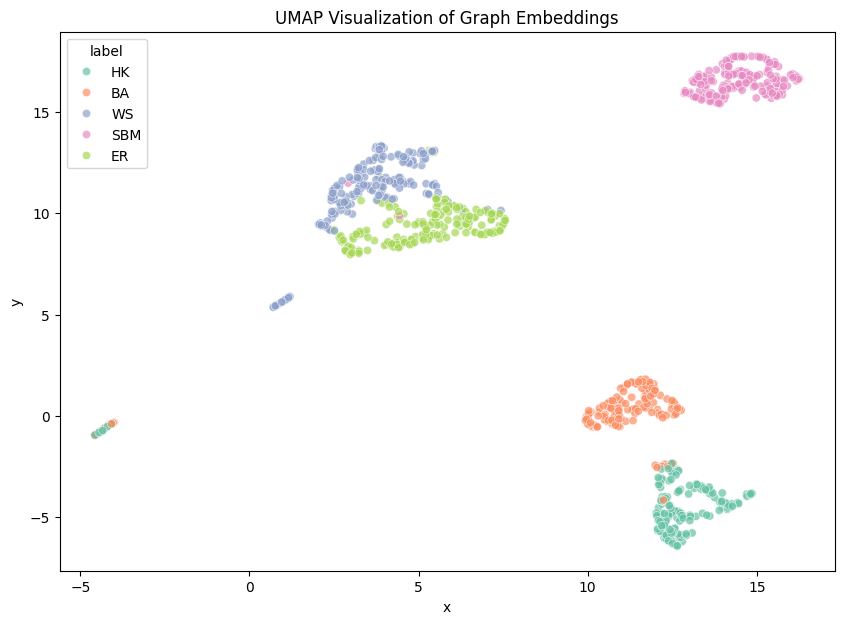

In [78]:
#set up model candidates,select based on optuna tuning
model_GAT = GraphFamilyClassifierGAT(in_channels = num_node_features, hidden_channels = best_params['hidden_channels'], num_classes = 5, graph_feature_dim = num_graph_features, dropout_rate = best_params['dropout_rate']).to(device)
model_GCN = GraphFamilyClassifierGCN(in_channels = num_node_features, hidden_channels = best_params['hidden_channels'], num_classes = 5, graph_feature_dim = num_graph_features, dropout_rate = best_params['dropout_rate']).to(device)
model_SAGE = GraphFamilyClassifierSAGE(in_channels = num_node_features, hidden_channels = best_params['hidden_channels'], num_classes = 5, graph_feature_dim = num_graph_features, dropout_rate = best_params['dropout_rate']).to(device)
model_GIN = GraphFamilyClassifierGIN(in_channels = num_node_features, hidden_channels = best_params['hidden_channels'], num_classes = 5, graph_feature_dim = num_graph_features, dropout_rate = best_params['dropout_rate']).to(device)
model_GATV2 = GraphFamilyClassifierGATV2(in_channels = num_node_features, hidden_channels = best_params['hidden_channels'], num_classes = 5, graph_feature_dim = num_graph_features, dropout_rate = best_params['dropout_rate']).to(device)
model_GTN = GraphFamilyClassifierGTN(in_channels = num_node_features, hidden_channels = best_params['hidden_channels'], num_classes = 5, graph_feature_dim = num_graph_features, dropout_rate = best_params['dropout_rate']).to(device)

models = [model_GAT, model_GCN, model_SAGE, model_GIN, model_GATV2, model_GTN]

name = names[best_model_type]
model = models[best_model_type]
print(f"Best model: {name}")
print(f"Best hyperparameters for {name}:")
print(f"Hidden channels: {best_params['hidden_channels']}")
print(f"Learning rate: {best_params['learning_rate']}")
print(f"Dropout rate: {best_params['dropout_rate']}")
optimizer = torch.optim.Adam(model.parameters(), lr=best_params['learning_rate'])
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)
criterion = nn.CrossEntropyLoss()

print(f"Training {name}")
train_loss, train_acc, validation_loss, validation_acc,  = training_loop(model, optimizer, scheduler, criterion, train_loader, test_loader, device, patience = 10)
metrics = [train_loss, train_acc, validation_loss, validation_acc]
print(f"Evaluating {name}")
comprehensive_evaluation(model, test_loader, device, metrics)